<div class="alert alert-block alert-success"> 
<h1> EDA and Plotly </h1>

# Overview

[**Plotly**](https://plotly.com/python/) is a Montreal based technical computing company involved in development of data analytics and visualisation tools such as Dash and Chart Studio. It has also developed open source graphing Application Programming Interface (API) libraries for Python, R, MATLAB, Javascript and other computer programming languages.

We would like to *emphasize* the following advantage of Plotly, especially from the EDA point of view:

- Plotly **assumes many variables** so many functions can be done with **a few line of code** especially through plotly.express, so one can focus on what's important. The result of plotly.express is accessible to other plotly functions, so one can draw and then fine tune.
- (*More importantly*) Plotly graphs are **interactive** in nature. This features turns out to be very useful for EDA.

Before going, one more note: *Like all other libraries, there are many cool things one can do with plotly, so here we are only going to show **a few examples**. Please refer to the [official gallery](https://plotly.com/python/) for more resources.*

#### Omission
*Load data and some necesary tweaks, not important for this presentation*

Note: *we use the same dataset as the last presentation*

In [2]:
import numpy as np
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
from ipywidgets import interactive, HBox, VBox, widgets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support,accuracy_score 
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
%config InlineBackend.figure_format = 'retina'

In [3]:
df_hr = pd.read_excel('HR_Employee_Data.xlsx')

In [4]:
# group columns
cat_vars = ['Work_accident', 'promotion_last_5years', 'Department', 'salary']
num_vars = ['satisfaction_level', 'last_evaluation','number_project','average_montly_hours', 'time_spend_company']
all_vars = cat_vars + num_vars
vars_dict = {
    'satisfaction_level':"Satisfaction Level",
    'last_evaluation':"Last Evaluation",
    'number_project':"Number of Project",
    'average_montly_hours':"Average Working Hours",
    'time_spend_company':"Commuting Hours",
    'Work_accident':"Work Accident or Not",
    'promotion_last_5years':"Promoted in Last 5 Years",
    'Department':"Department", 
    'salary':"Salary Level",
    'left':"Left the Position"
}
vars_explain = {
    'satisfaction_level':"Satisfaction level of employee in percentage. 1 is very satisfied. 0 is not satisfied",
    'last_evaluation':"Time from last evaluation in years",
    'number_project':"Number of projects an employee is working on",
    'average_montly_hours':"Average hours worked by employee in last 3 months",
    'time_spend_company':"Time spend by employee commuting to office (presumably in hours)",
    'Work_accident':"If the employee was involved in a work accident",
    'promotion_last_5years':"If the employee has a promotion in past 5 years",
    'Department':"Department employee is working in", 
    'salary':"Salary Level",
    'left':"If the employee has left the company"
}

for col in ["Work_accident","promotion_last_5years"]:
    df_hr[col] = df_hr[col].replace({0:"No",1:"Yes"})
df_hr['left_cat'] = df_hr['left'].replace({0:"Stay",1:"Left"})

df1 = df_hr.query("left == 1").copy()
df0 = df_hr.query("left == 0").copy()

# Exploration: the Extensive Aspect

EDA has so many ways to go. Specifically, for each column, there's so many metrics to summarize and so many figures to plot. It often leadds to either of the two issues:

- Manually change the column name to change the figure: too tedious
- Use loop to plot all figures at one: too spacy

It would be better if the figures can be plotted in a batch and changeable through clicks.

## Univariate: Histogram, switch column with button

Through `update` method in plotly. Everyone we click the button from the dropdown menu, it instructs to change the data input accordingly.

Furthermore, **histogram** and **bar plot** are made as **interchangeable** as possible in plotly, which makes it more convenient to plot every feature/column at once without worrying too much about which type of plot to choose.

Note: *we also put column description as title to remind us on the background information of each column*

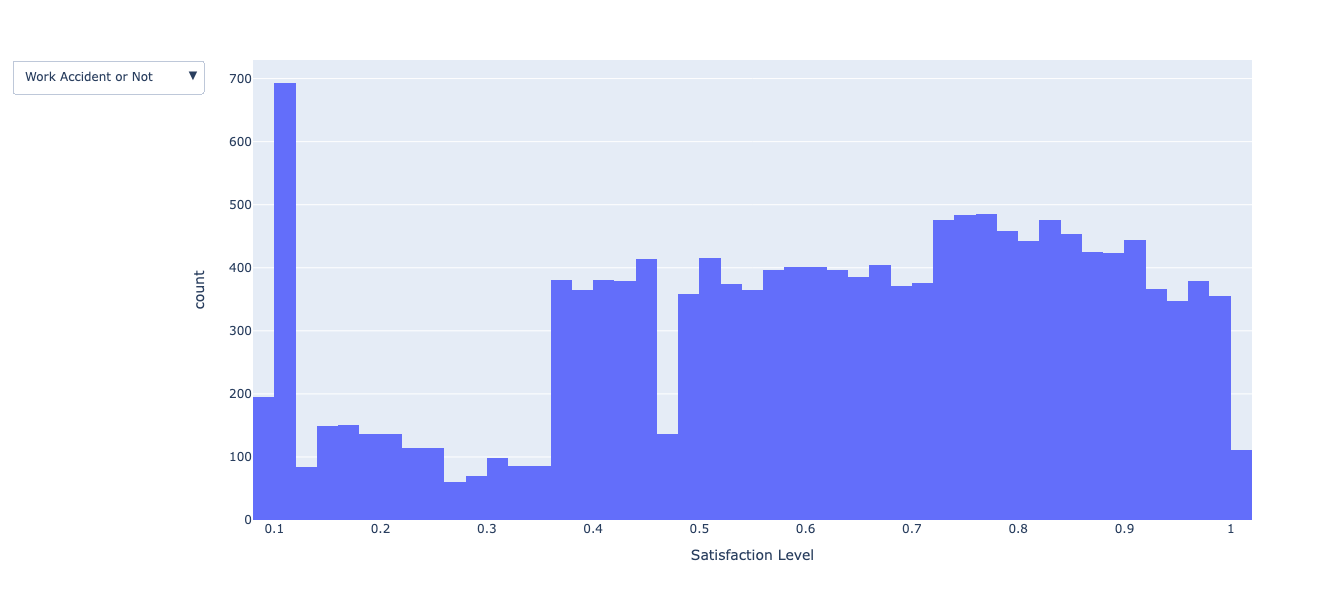

In [5]:
fig = px.histogram(df_hr,x="satisfaction_level")
fig.update_layout(xaxis_title_text=vars_dict['satisfaction_level'],width=1000)
buttons = []
for col in all_vars:
    buttons.append(dict(
            method="update",
            label=vars_dict[col],
            args=[{"x":[df_hr[col]]},{'title':vars_explain[col],'xaxis': {'title': vars_dict[col]}}]
        )    
    )
fig.update_layout(updatemenus=[dict(buttons=buttons)],width=1000,height=600)
fig.show()

## Bivariate: Side by Side Compare Left and Stay

### Numeric Columns

Aside from updating the data, we can also achieve the similar goal by updating on `visible`. This time, clicking each button in the dropdown menu will instruct to reveal the desired plots while hide other plots.

This is useful when the figures are more complicated and hard to directly change the input, like this case. We want to plot the distributions of a feature side by side between employees to left and those who stay.

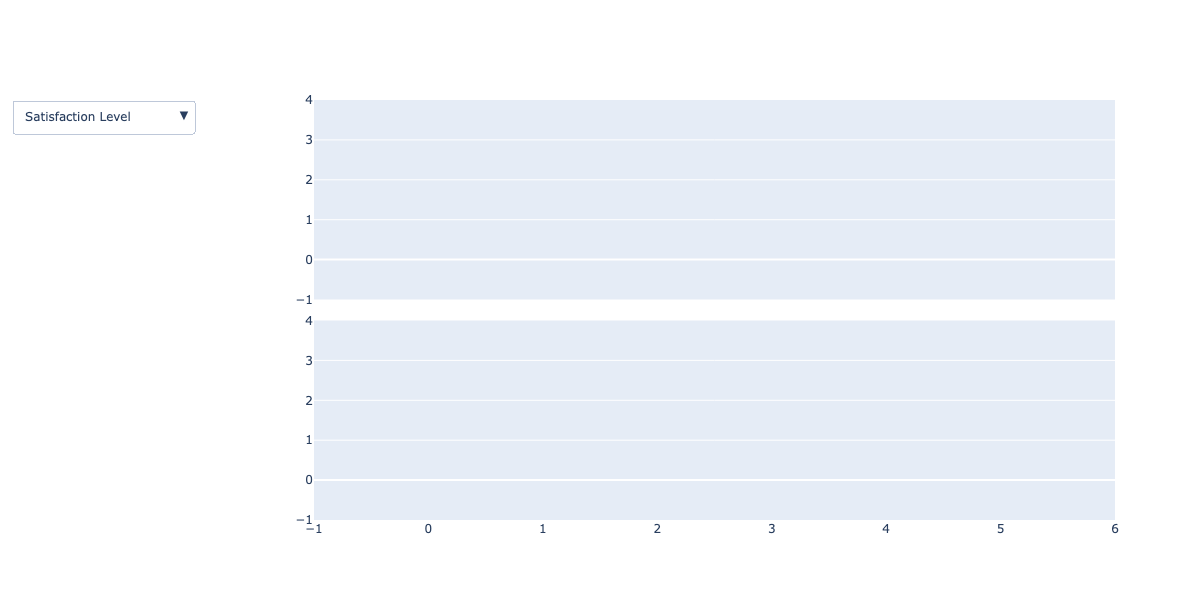

In [21]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,vertical_spacing = 0.05)
visibility = [False for i in range(len(num_vars)*2)]
buttons = []
for i in range(len(num_vars)):
    col = num_vars[i] 
    fig.add_trace(go.Histogram(x=df1[col], visible=False, name = "Left"),row=1, col=1)
    fig.add_trace(go.Histogram(x=df0[col], visible=False, name = "Stay"),row=2, col=1)
    visibility_temp = visibility.copy()
    visibility_temp[i*2] = True
    visibility_temp[i*2+1] = True
    buttons.append(dict(
        method = 'update',label = vars_dict[col],
        args = [{"visible":visibility_temp}]
    ))
fig.update_layout(width=1000,height=600)
fig.update_layout(updatemenus=[dict(buttons=buttons,x=-0.15)])
fig.show()

### Categorical Variable
The same can be done for categorical variables

Note: *We tried to plot all variables together, but currently the result doesn't behave as expected, so we have to split them, at least for now*

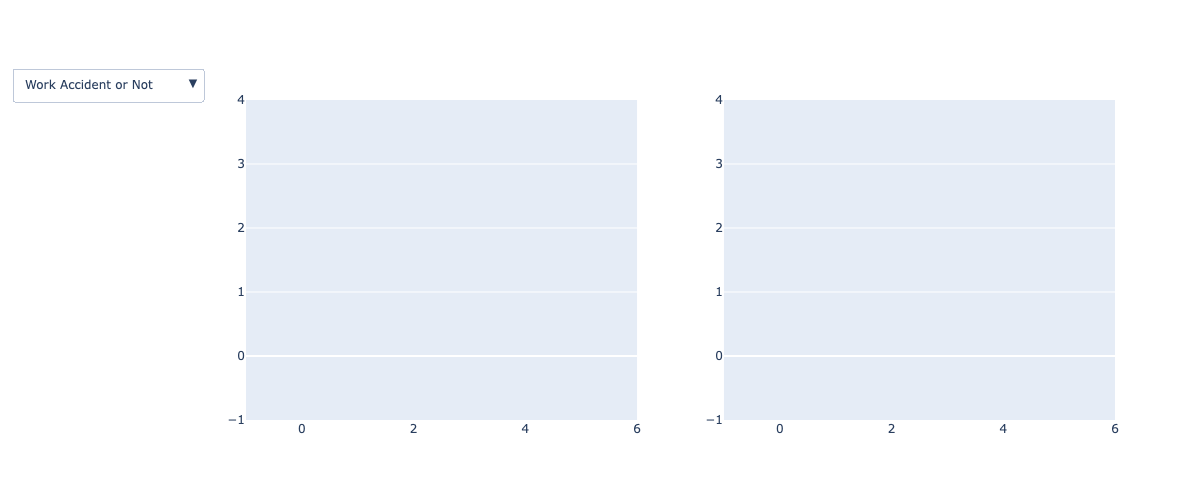

In [22]:
#categorical
fig = make_subplots(rows=1, cols=2,shared_xaxes='all')
visibility = [False for i in range(len(cat_vars)*2)]
buttons = []
for i in range(len(cat_vars)):
    col = cat_vars[i]
    count1 = df1[col].value_counts()
    count0 = df0[col].value_counts()
    fig.add_trace(go.Bar(x=count1.index,y=count1.values,visible=False,name = "Left"),row=1,col=1)
    fig.add_trace(go.Bar(x=count0.index,y=count0.values,visible=False, name = "Stay"),row=1,col=2)
    visibility_temp = visibility.copy()
    visibility_temp[i*2] = True
    visibility_temp[i*2+1] = True
    buttons.append(dict(
        method = 'update',label = vars_dict[col],
        args = [{"visible":visibility_temp}]
    ))

fig.update_layout(updatemenus=[dict(buttons=buttons,y=1.1)],width=1000,height=500)
iplot(fig)        

## Bivariate: 2D heatmap

Perhaps you think 9 is not a huge number so it is still feasible to squeeze everything together, but when we move from univariate to more than one features, the number of possible plots rise exponentially.

For bivariate plot (e.g. heatmap), there are $\binom{9}{2}=36$ possiblities. Good luck with fitting them into one page!

Using `Widget` functionality (built on Jupyter Widgets), we can update features of interest with a few clicks and let plotly to automaticall fetch the data and draw the plot.

In [24]:
f = go.FigureWidget([
    go.Histogram2d(x=df_hr['average_montly_hours'],y=df_hr['number_project'],colorscale="Blues",texttemplate= "%{z}",textfont=dict(size=9))
])
f.update_layout(xaxis_title_text=vars_dict['average_montly_hours'],yaxis_title_text=vars_dict['number_project'],
                width=700,height=600,margin=dict(pad=5),font=dict(size=15))
heatmap = f.data[0]
def update_axes(xaxis, yaxis):
    heatmap = f.data[0]
    heatmap.x = df_hr[xaxis]
    heatmap.y = df_hr[yaxis]
    with f.batch_update():
        f.layout.xaxis.title = vars_dict[xaxis]
        f.layout.yaxis.title = vars_dict[yaxis]
axis_dropdowns = interactive(update_axes, yaxis = all_vars, xaxis = all_vars)
VBox((HBox(axis_dropdowns.children),f))

*E.g. Observation: A clear positive association between Number of Projects and Average Working Hours; that means employees who work on more projects tend to overwork*

## Multivariate: 2D Heatmap with Aggregation

With additional arguments, we can bring the response variable **"left rate"** into the picture. Essentially, we change the heatmap from simple count to calculating the percentage of employees who have left.

In [23]:
f = go.FigureWidget([
    go.Histogram2d(x=df_hr['average_montly_hours'],y=df_hr['number_project'],
    z=df_hr['left'],histfunc="avg",colorscale="Blues",texttemplate= "%{z:.1f}",colorbar=dict(title="Left Rate"),textfont={"size":9})
])
f.update_layout(xaxis_title_text=vars_dict['average_montly_hours'],yaxis_title_text=vars_dict['number_project'],
                width=700,height=600,margin=dict(pad=5),font=dict(size=15))
heatmap = f.data[0]
def update_axes(xaxis, yaxis):
    heatmap = f.data[0]
    heatmap.x = df_hr[xaxis]
    heatmap.y = df_hr[yaxis]
    with f.batch_update():
        f.layout.xaxis.title = vars_dict[xaxis]
        f.layout.yaxis.title = vars_dict[yaxis]
axis_dropdowns = interactive(update_axes, yaxis = all_vars, xaxis = all_vars)
VBox((HBox(axis_dropdowns.children),f))

*E.g. Observation: employees who have left cluster around the following places:*
- *1) top right peripery - overworking folks*
- *2) the bottom left - underachieving folks* 
- *3) mid-upper-right - receiving better offers?*

# Visualization and Report: the Intensive Aspect

## Hovering Information

Many of us perhaps have realized that one great power of EDA, especially the visualization aspect, is that so much information can be presented with seemingly simple plot. Plotly can add more to it using the hovering information.

Plotly plots automatically create **hovering** information for the data used to plot the graph, but to unlock the potential of this feature, we need to make use of `customdata`. This argument in the function receives array (whose outer dimensions should have the same dimensions as the plotted data). Then we can call it in `hovertemplate` (*using `d3-format` syntax*) to fine tune the display.

In [10]:
# get associated metrics
avg = df_hr.pivot_table(values="average_montly_hours",index='number_project',columns="left_cat")
count = df_hr.pivot_table(values="average_montly_hours",index='number_project',columns="left_cat",aggfunc="count").fillna(0)
count["Left_per"] = count['Left'] / (count['Stay'] + count['Left']) * 100
count["Stay_per"] = count['Stay'] / (count['Stay'] + count['Left']) * 100

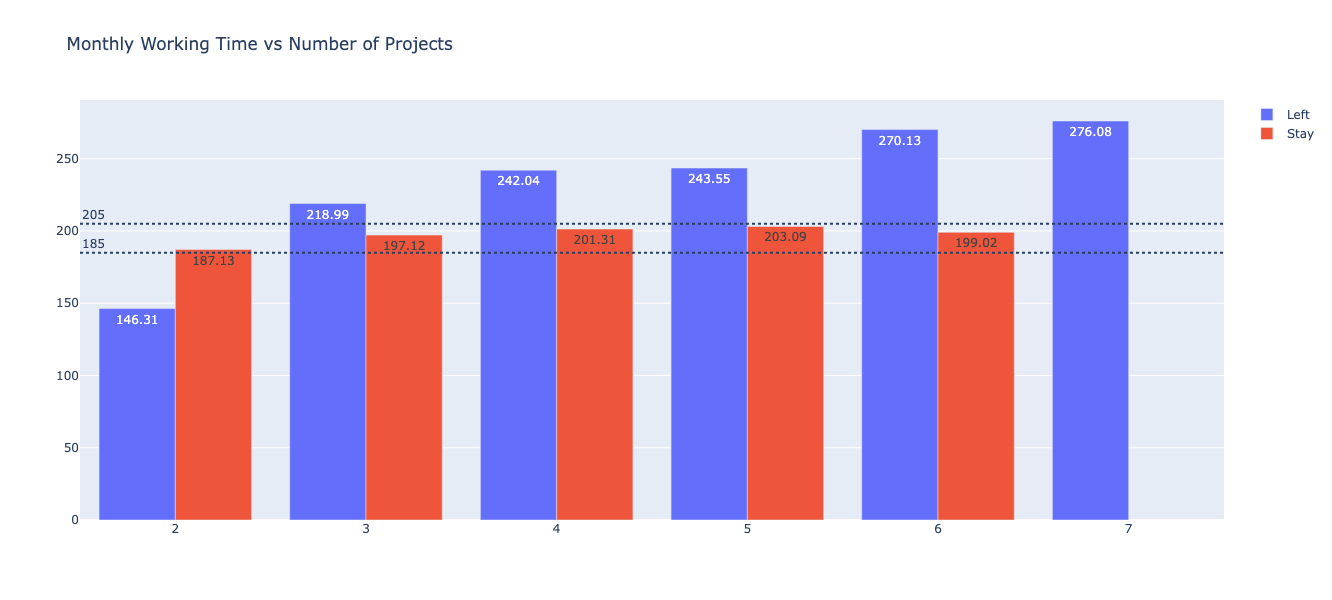

In [11]:
# plotting
fig = go.Figure()
hovertemplate="<i>Number of Project</i>: %{x}" +\
              "<br><b>Mean of Average Monthly Working Hours: %{y:.1f}</b><br>" +\
              "<br><b>Head Count: %{customdata[0]}<br>" +\
              "In Level %: %{customdata[1]:.2f}%"
fig.add_hline(y=185,line_dash="dot",annotation_text="185",annotation_position="top left")
fig.add_hline(y=205,line_dash="dot",annotation_text="205",annotation_position="top left")
fig.add_trace(go.Bar(x=avg.index,y=avg['Left'].values,name='Left',text=np.round(avg['Left'].values,2),
                     hovertemplate=hovertemplate,customdata = count[["Left","Left_per"]].values))
fig.add_trace(go.Bar(x=avg.index,y=avg['Stay'].values,name='Stay',text=np.round(avg['Stay'].values,2),
                     hovertemplate=hovertemplate,customdata = count[['Stay','Stay_per']].values))
fig.update_layout(width=1000,height=600,title="Monthly Working Time vs Number of Projects")

What key information does this graph display:
1) There is **not a single person** who stayed in the company who worked on **7 projects**. This indicates that the company should look into not giving more than 6 projects at a time to an employee. More than 7 projects can lead to exhaustion for an employee.
2) The people who left **worked more monthly hours** for the same project amount than the people who stayed. This implies that fatigue played a role in them leaving the company. However, this trend is the opposite, in the case of people who worked 2 projects only. In this case, surprisingly, people who worked less monthly hours left the company. This can imply that the employees who worked on two projects and left needed more career fufillment and growth opportunities.
3) The average monthly hours worked for all the employees who stayed remains between **185 and 205** hours regardless of the number of projects. However, for all the employees who left, the average monthly time increased as the number of projects increased.


#### Having doubt?
*OK, some audience may have doubt in conclusion 3), saying what's shown here are simply averages and don't take the sampling distribution into account. To address this challenge, we would like to make sure of one plotly's interactive feature: **Plotting different graphs for the same data at the same time**. Here aside from bar chat, we also plot **box plot** and **violin plot** to show that the same conclusion holds for the overall samples*

In [12]:
fig = px.histogram(df_hr,x='number_project',y='average_montly_hours',histfunc="avg",
                   color='left_cat',barmode="group",
                   labels={"number_project":"Number of Projects",
                           "average_montly_hours":"Monthly Hours",
                           "left_cat":"Left"})
fig.add_hline(y=185,line_dash="dot",annotation_text="185",annotation_position="top left")
fig.add_hline(y=205,line_dash="dot",annotation_text="205",annotation_position="top left")
fig.update_layout(width=1000,height=600,title="Monthly Working Time vs Number of Projects")
fig.update_layout(updatemenus = [dict(type = "buttons",direction = "down",
    buttons=[
        dict(args = [{"type":"histogram"}], label = "Bar", method = "update"),
        dict(args = [{"type":"box"},{"boxmode":"group"}], label = "Box", method = "update"),
        dict(args = [{"type":"violin"},{"violinmode":"group"}], label = "Violin", method = "update")
    ],x=-0.1)])
fig.show()

# Geographic Information

Note: For the sake of this presentation, the geographic information in this dataset is simulated.

Don't Get Intimidated by the codes

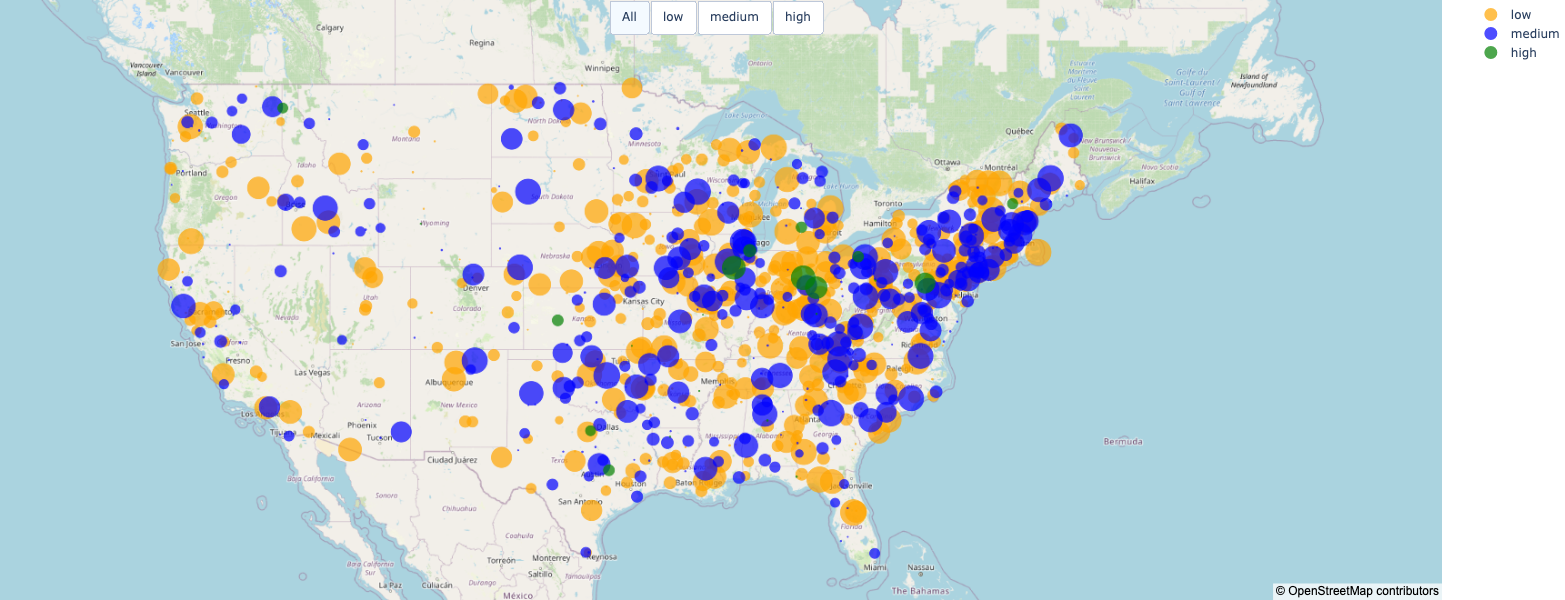

In [20]:
# sample data
df_c = pd.read_csv('us_cities.csv')
df_c  = df_c[df_c['LATITUDE'].notna() & df_c['LONGITUDE'].notna() & df_c['COUNTY'].notna() & df_c['CITY'].notna()]
df_c.dropna(axis = 0, inplace = True)
df_c.isnull().sum()
latloncc = df_c[['LATITUDE', 'LONGITUDE', 'CITY','COUNTY']].sample(14999)\
.rename({'LATITUDE':'lat', 'LONGITUDE':'lon', 'CITY':'city','COUNTY':'county'}, axis = 1).reset_index()

df_hr['lat'] = latloncc['lat']
df_hr['lon'] = latloncc['lon']
df_hr['city'] = latloncc['city']
df_hr['county'] = latloncc['county']

# Initialize figure
fig = go.Figure()

sal = ['all', 'low', 'medium', 'high']
col_d = {'all': None, 'low':'orange', 'medium': 'blue', 'high': 'green'}

df_scatter = df_hr[df_hr['left'] == 1].sample(1000)

#Add Traces
fig.add_trace(
    go.Scattermapbox(
            lat = df_scatter[df_scatter['salary'] == 'low'].lat,
            lon = df_scatter[df_scatter['salary'] == 'low'].lon,
            name = 'low',
            mode='markers',
            customdata=df_scatter,
            hovertemplate='City: %{customdata[14]}<br>Satisfaction Score: %{customdata[1]}<br>Dept: %{customdata[9]}<br>Promoted: %{customdata[8]}<extra></extra>',
            marker=go.scattermapbox.Marker(
                size = df_scatter['satisfaction_level'] * 30,
                color = col_d['low']
            )
            ))
#scatterplot for medium salary
fig.add_trace(
    go.Scattermapbox(
            lat = df_scatter[df_scatter['salary'] == 'medium'].lat,
            lon = df_scatter[df_scatter['salary'] == 'medium'].lon,
            name = 'medium',
            mode='markers',
            customdata=df_scatter,
            hovertemplate='City: %{customdata[14]}<br>Satisfaction Score: %{customdata[1]}<br>Dept: %{customdata[9]}<br>Promoted: %{customdata[8]}<extra></extra>',
            marker=go.scattermapbox.Marker(
                size = df_scatter['satisfaction_level'] * 30,
                color = col_d['medium']
            )
            ))
#scatterplot for high salary
fig.add_trace(
    go.Scattermapbox(
            lat = df_scatter[df_scatter['salary'] == 'high'].lat,
            lon = df_scatter[df_scatter['salary'] == 'high'].lon,
            name = 'high',
            mode='markers',
            customdata=df_scatter,
            hovertemplate='City: %{customdata[14]}<br>Satisfaction Score: %{customdata[1]}<br>Dept: %{customdata[9]}<br>Promoted: %{customdata[8]}<extra></extra>',
            marker=go.scattermapbox.Marker(
                size = df_scatter['satisfaction_level'] * 30,
                color = col_d['high']
            )
            ))

# add buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.57,
            y=1,
            buttons=list([
              #add button to show all three scatter plots: "visible": [True, True, True]}
                dict(
                  label = "All", method = "update",
                  args = [{"visible": [True, True, True]},{"title": "All Employees"} ]
               ),
               #add button to show low only
                dict(
                  label = "low", method = "update",
                  args = [{"visible": [True, False, False]},{"title": "Employees in low Salary range"} ]
               ),
            #add button to show med only
               dict(
                  label = "medium", method = "update",
                  args = [{"visible": [False, True, False]},{"title": "Employees in medium Salary range"} ]
               ),
            #add button to show high only
               dict(
                  label = "high", method = "update",
                  args = [{"visible": [False, False, True]},{"title": "Employees in high Salary range"} ]
               ),
            ]),
        )
    ])
fig.update_layout(
    mapbox=dict(
        style = 'open-street-map',
        bearing = 0,
        center = go.layout.mapbox.Center(
            lat = df_scatter['lat'].mean(),
            lon = df_scatter['lon'].mean(),
        ),
        zoom = 3.5
    ),
    margin={'r':10, 't': 0, 'l': 0, 'b': 0}
)
fig.update_layout(autosize=False,width=1000,height=600)
fig.show()

# Model Fitting

Yes, we've emphasized that EDA is the very first step, but we'd also like to remind you that EDA is not confined within the "first step". It can still be useful in later steps, such as model fitting. Here, we'll go over an example where plotly helps make a better visualization.

In [14]:
# fitting logistic regression
y = np.array(df_hr['left'].values)
x = np.array(df_hr[num_vars].values)
model = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)
cm = confusion_matrix(y, model.predict(x))

metrics = precision_recall_fscore_support(y, model.predict(x),average='binary')
accuracy = accuracy_score(y, model.predict(x))

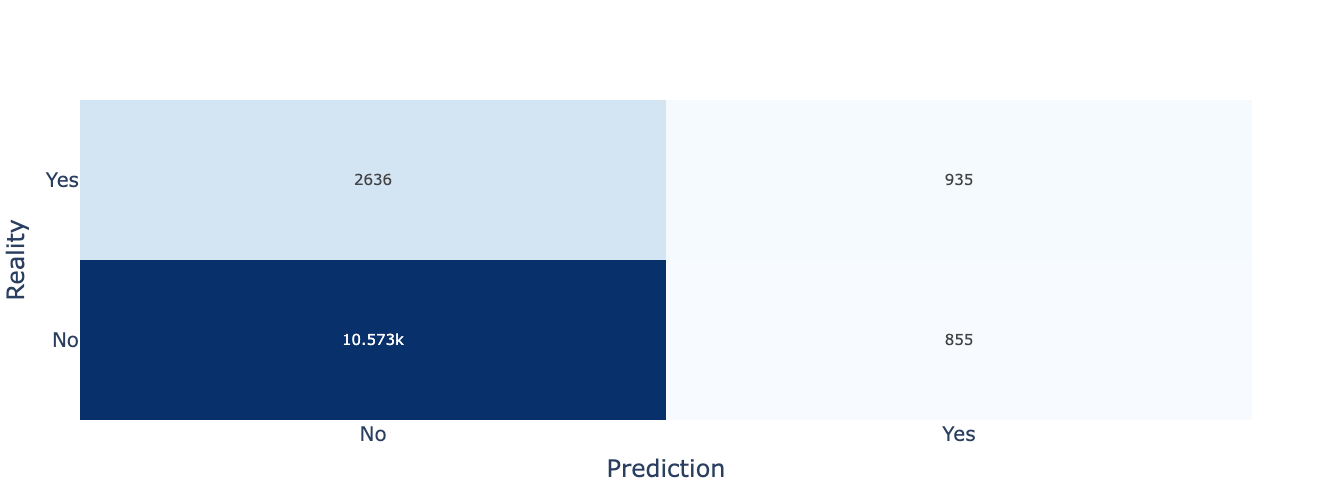

In [15]:
# plotting
text = [[f"Accuracy: {accuracy:.2f}",f"Precision: {metrics[0]:.2f}"],
        [f"Recall: {metrics[1]:.2f}",f"F1: {metrics[2]:.2f}"]]

fig = go.Figure(data=go.Heatmap(x=['No', 'Yes'],y=['No', 'Yes'],z=cm,colorscale="Blues",text=text,texttemplate="%{z}",
               hovertemplate = "Pred: %{x}<br>Real: %{y}<br>Count: %{z}<br><b>%{text}</b>",showscale=False,textfont=dict(size=15)))
fig.update_layout(xaxis_title="Prediction",yaxis_title="Reality",font=dict(size=20),width=500,height=500)

<div style="border-radius:10px; border: #682F2F solid; background-color:#e1f6e1; font-size:100%; padding-left:10px; text-align:left">
<h2>Last: Conclusion, or Onwards </h2>
EDA accompanies us throughout the entire data science project journey, and plotly brings a better experience through its interactive nature

- Feature overview and selection
- Business decisions and presentation
- Model selection